In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


from torchinfo import summary


import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
# Đọc dữ liệu đã gộp
df = pd.read_csv("/content/drive/MyDrive/CS-P-CSBU111/Colab/Dataset/merged.csv")

df.head(1)

<ipython-input-3-0173858fc59b>:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/CS-P-CSBU111/Colab/Dataset/merged.csv")


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,21243,192.168.50.6-23.194.142.213-57215-443-6,192.168.50.6,57215,23.194.142.213,443,6,2018-12-01 11:22:40.970628,20740,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN


In [ ]:
# Xóa các cột không cần thiết
columns_to_drop = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
df = df.drop(columns_to_drop, axis=1, errors='ignore')

In [ ]:
# Drop the 'Unnamed: 0' column if it exists
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [ ]:
# Loại bỏ giá trị NaN
df = df.dropna()

In [ ]:
# Chuyển đổi nhãn thành nhị phân (DDoS hoặc không)
df[' Label'] = df[' Label'].apply(lambda x: 1 if 'DDoS' in x else 0)

In [ ]:
# Tách đặc trưng và nhãn
X = df.drop(' Label', axis=1)
y = df[' Label']

In [ ]:
# Identify and handle non-numeric columns
for column in X.select_dtypes(include=['object']).columns:
    # You can choose to drop non-numeric columns if they are irrelevant
    # X = X.drop(columns=[column])
    # Or encode them using Label Encoding:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))

In [ ]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

X.dropna(inplace=True)

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Lưu dữ liệu đã xử lý
processed_data = pd.DataFrame(X, columns=df.columns[:-1])

# Reset index of y to match the processed data
y = y.reset_index(drop=True)

# Align y with the processed data using the reset index
processed_data['Label'] = y

processed_data.to_csv("/content/drive/MyDrive/CS-P-CSBU111/processed_cicddos2019.csv", index=False)

In [ ]:
df.columns

Index([' Source Port', ' Destination Port', ' Protocol', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std',

In [ ]:
# Get the current index of X after preprocessing
# current_index = y.index  # This line is causing the problem

# Align y with the processed data using the index of X
current_index = pd.RangeIndex(0, len(X)) # Get the index of X after preprocessing
y = y.iloc[current_index].reset_index(drop=True)

# Now X and y should have the same number of rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Dataset cho PyTorch
class DDoSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # unsqueeze để tạo channel cho CNN

train_dataset = DDoSDataset(X_train, y_train)
test_dataset = DDoSDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Mô hình CNN
class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # Calculate the correct input size for fc1 after convolutions and pooling
        self.fc1 = nn.Linear(32 * (input_size // 4) , 128)  # Adjusted calculation for input_size
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [ ]:
# Instantiate the model
input_size = 100  # Example input size
model = CNN(input_size)

In [ ]:
# Summary of the model with input size: (batch_size, channels, input_length)
batch_size = 64  # Example batch size
summary(model, input_size=(batch_size, 1, input_size), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
CNN                                      [64, 1, 100]              [64, 1]                   --                        True
├─Conv1d: 1-1                            [64, 1, 100]              [64, 16, 100]             64                        True
├─MaxPool1d: 1-2                         [64, 16, 100]             [64, 16, 50]              --                        --
├─Conv1d: 1-3                            [64, 16, 50]              [64, 32, 50]              1,568                     True
├─MaxPool1d: 1-4                         [64, 32, 50]              [64, 32, 25]              --                        --
├─Linear: 1-5                            [64, 800]                 [64, 128]                 102,528                   True
├─Linear: 1-6                            [64, 128]                 [64, 1]                   129                       True
├─Sigmo

In [ ]:
# Khởi tạo mô hình
input_size = X_train.shape[1]
model = CNN(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_accuracies = []
    test_accuracies = []
    losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy for training
            predictions = (outputs > 0.5).float()
            correct_train += (predictions == y_batch).sum().item()
            total_train += y_batch.size(0)

        # Calculate accuracy on the training set
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        losses.append(running_loss / len(train_loader))

        # Evaluate on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch).squeeze()
                predictions = (outputs > 0.5).float()
                correct_test += (predictions == y_batch).sum().item()
                total_test += y_batch.size(0)

        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Loss: {running_loss / len(train_loader):.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Test Accuracy: {test_accuracy:.4f}"
        )

    return train_accuracies, test_accuracies, losses



In [ ]:
train_accuracies, test_accuracies, losses = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=10
)

Epoch 1/10, Loss: 0.0037, Train Accuracy: 0.9995, Test Accuracy: 0.9996
Epoch 2/10, Loss: 0.0030, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 3/10, Loss: 0.0030, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 4/10, Loss: 0.0030, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 5/10, Loss: 0.0031, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 6/10, Loss: 0.0029, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 7/10, Loss: 0.0029, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 8/10, Loss: 0.0029, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 9/10, Loss: 0.0029, Train Accuracy: 0.9996, Test Accuracy: 0.9996
Epoch 10/10, Loss: 0.0029, Train Accuracy: 0.9996, Test Accuracy: 0.9996


In [ ]:
# Lưu toàn bộ mô hình
torch.save(model, "model_2.pt")
print("Full model has been saved successfully!")


# Tải trạng thái từ file .pt
model = torch.load("ddos_model_full.pt")
model.eval()
print("Full model has been loaded successfully!")

Full model has been saved successfully!
Full model has been loaded successfully!


<ipython-input-30-e36e4e49294e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("ddos_model_full.pt")


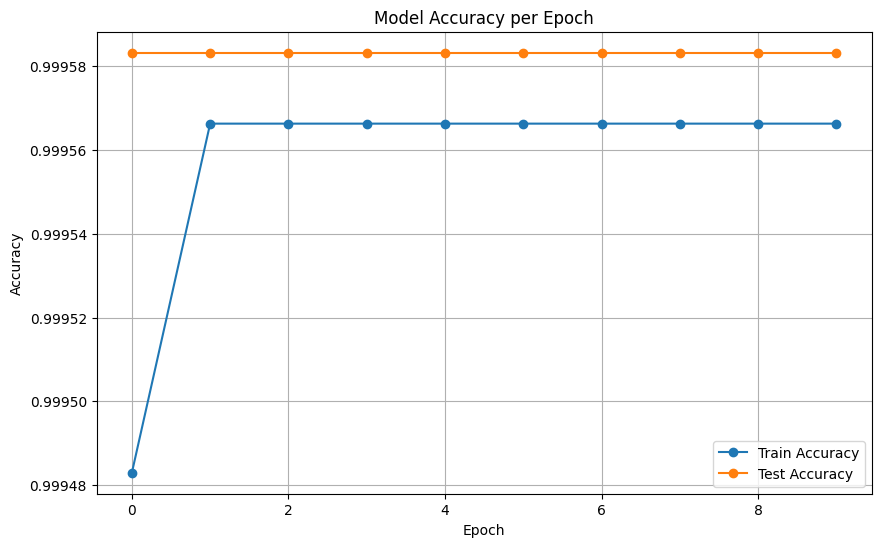

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(test_accuracies, label="Test Accuracy", marker="o")
plt.title("Model Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


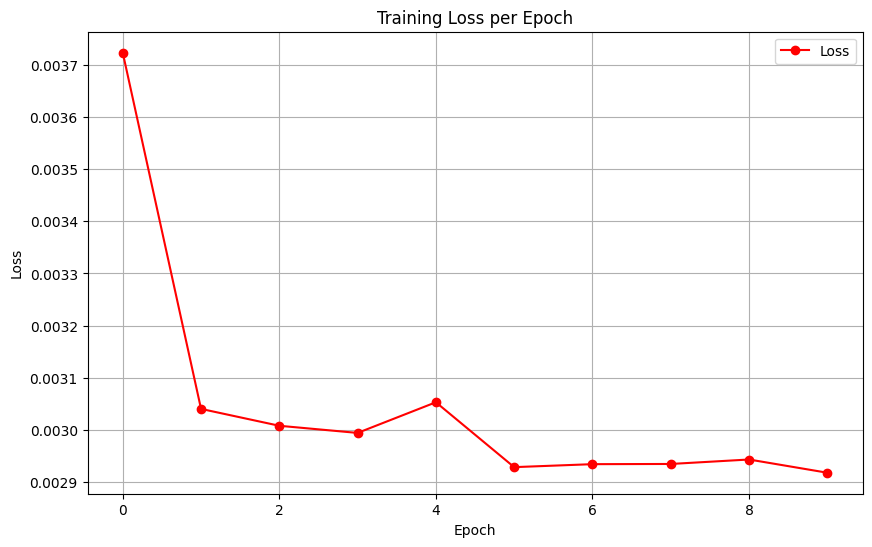

In [ ]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss", marker="o", color="red")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
